In [1]:
%run functions.ipynb

np.set_printoptions(precision=3)
np.random.seed(42)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
labels = load_file('data/labels_for_microarray_data.csv')
dataset = load_file('data/microarray_data.csv')[:, 1:].T
print(labels.shape, dataset.shape)
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                        (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

(969,) (969, 12179)
Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


# How different normalizations influence weights of logistic regression 
(ESC + M/Y to chnage type to markdown code)

### No normalization

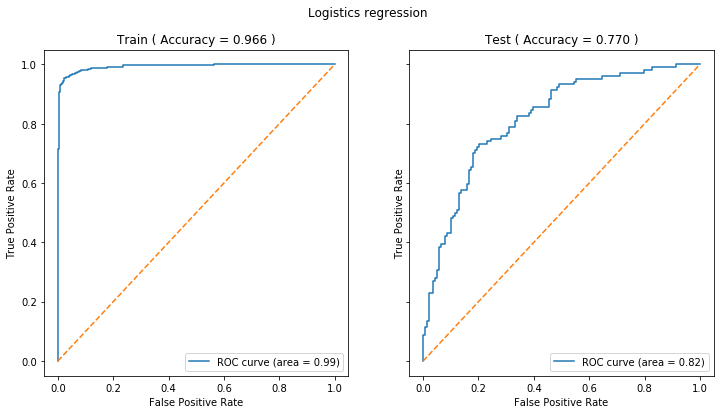

In [3]:
clf_logit_no_norm = fit_clf(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), X_train, y_train, X_test, y_test, "Logistics regression")

### Standarization

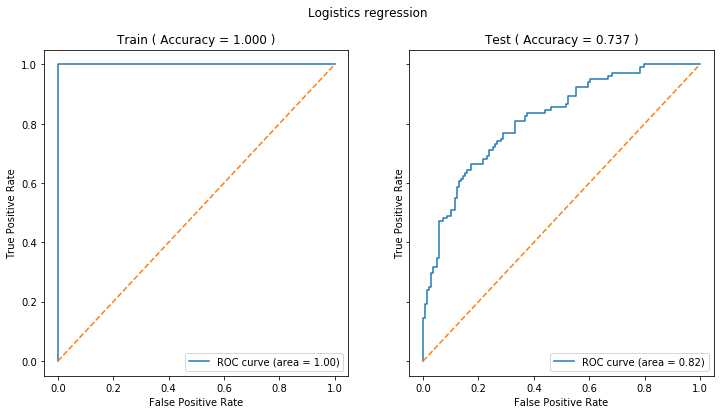

In [4]:
clf_logit_std = fit_clf(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), X_std_train, y_train, X_std_test, y_test, "Logistics regression")

### Quantile normalization from sklearn

In [5]:
normal_transformer = QuantileTransformer(n_quantiles=dataset.shape[0], output_distribution='normal')
uniform_transformer = QuantileTransformer(n_quantiles=dataset.shape[0], output_distribution='uniform')


normalized_train = normal_transformer.fit_transform(X_train)
normalized_test = normal_transformer.transform(X_test)

uniform_train = uniform_transformer.fit_transform(X_train)
uniform_test = uniform_transformer.transform(X_test)

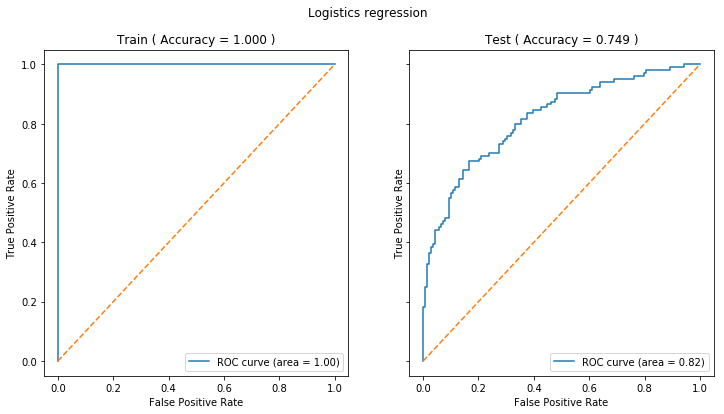

In [6]:
clf_logit_norm = fit_clf(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), normalized_train, y_train, normalized_test, y_test, "Logistics regression")

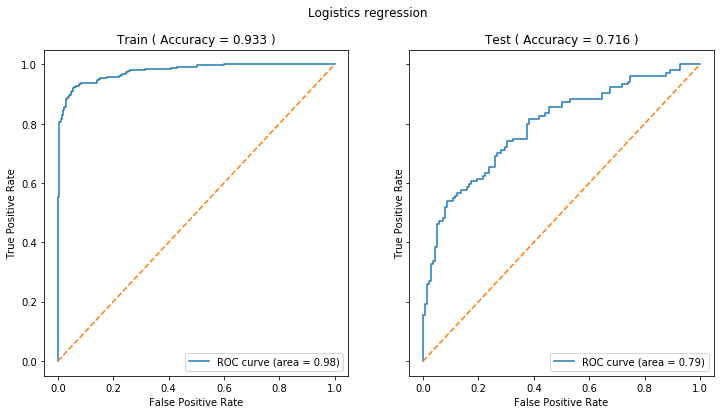

In [7]:
clf_logit_unif = fit_clf(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), uniform_train, y_train, uniform_test, y_test, "Logistics regression")

### Truncating most extreme values to 1% and 99% quantiles

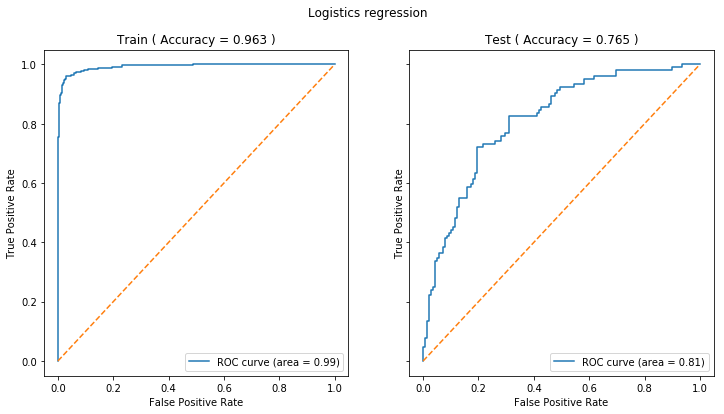

In [8]:
p = X_train.shape[1]

quantiles = np.zeros((2, p))

for i in np.arange(p):
    quantiles[:, i] = np.quantile(X_train[:, i], [0.01, 0.99])
    
X_train_trunc = np.array(X_train)
X_test_trunc = np.array(X_test)

    
for i in np.arange(p):
    X_train_trunc[:, i][X_train_trunc[:, i] > quantiles[1, i]] = quantiles[1,i]
    X_train_trunc[:, i][X_train_trunc[:, i] < quantiles[0, i]] = quantiles[0,i]
    
    X_test_trunc[:, i][X_test_trunc[:, i] > quantiles[1, i]] = quantiles[1,i]
    X_test_trunc[:, i][X_test_trunc[:, i] < quantiles[0, i]] = quantiles[0,i]
    
    
clf_logit_trunc = fit_clf(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), X_train_trunc, y_train, X_test_trunc, y_test, "Logistics regression")

### Subracting median and dividing by 75% qunatile - 25% qunatile

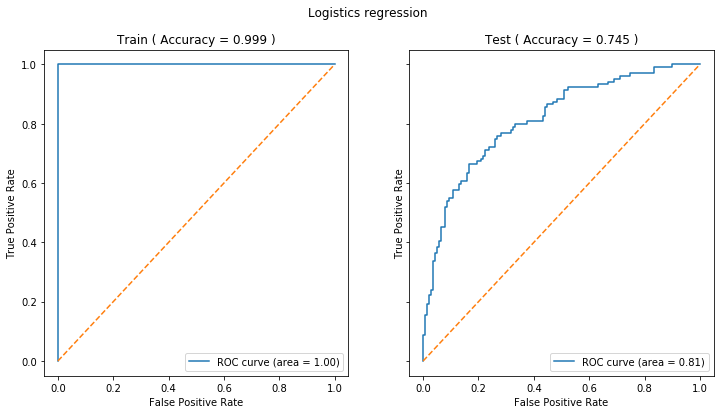

In [9]:
quantiles = np.zeros((3, p))

for i in np.arange(p):
    quantiles[:, i] = np.quantile(X_train[:, i], [0.25, 0.5, 0.75])
    
X_train_median = np.array(X_train)
X_test_median = np.array(X_test)
    
for i in np.arange(p):
    X_train_median[:, i] = (X_train_median[:, i] - quantiles[1, i])/(quantiles[2, i] - quantiles[0, i])
    X_test_median[:, i] = (X_test_median[:, i] - quantiles[1, i])/(quantiles[2, i] - quantiles[0, i])
    
clf_logit_median = fit_clf(LogisticRegression(solver="liblinear", penalty="l1", C=0.3), X_train_median, y_train, X_test_median, y_test, "Logistics regression")
#plot_logit_weights(clf_logit_median, 'Subratcting median, dividing by interquantile range')    

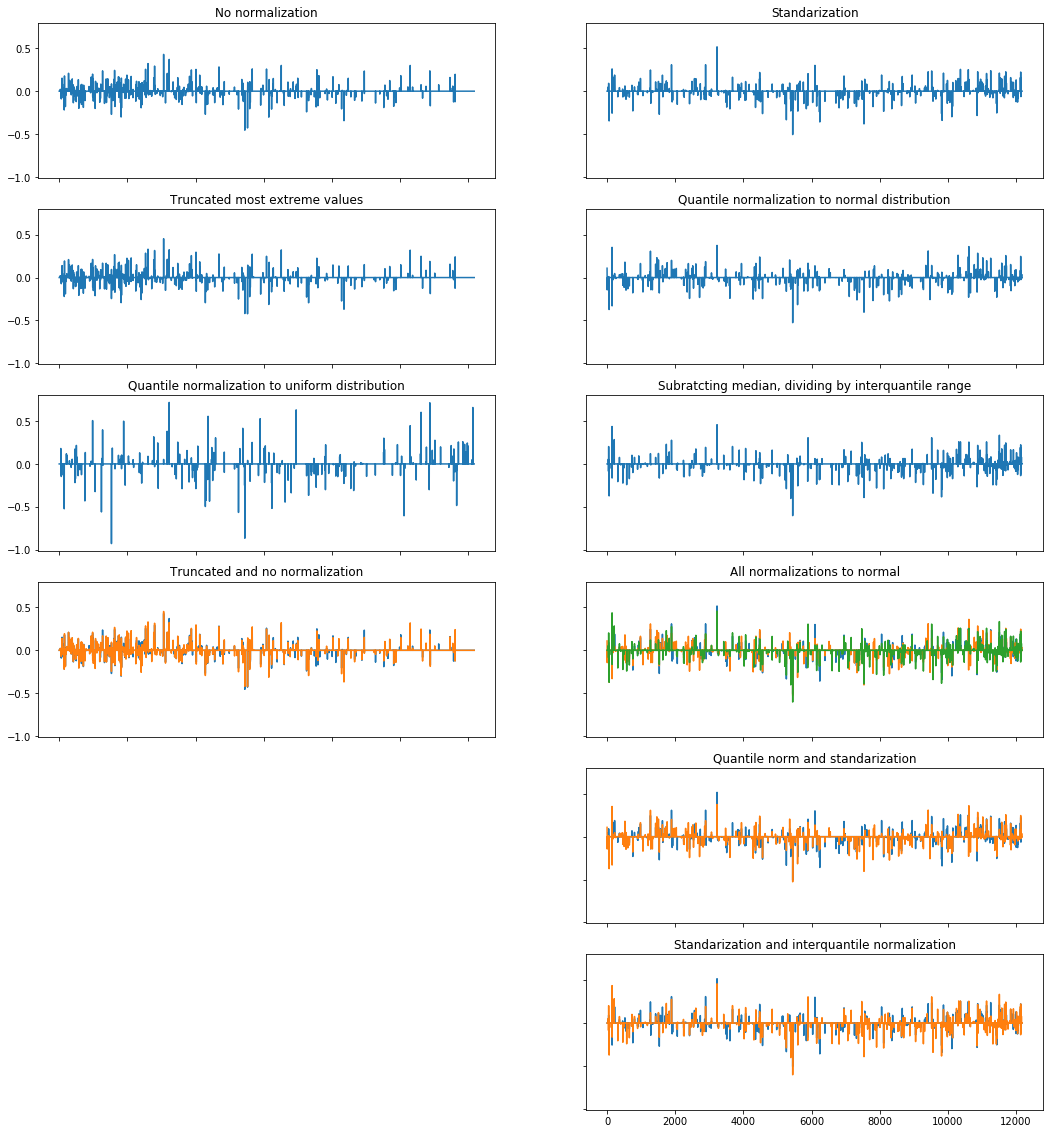

In [10]:
figure, axes = plt.subplots(nrows=6, ncols=2, sharex=True, sharey=True, figsize=(18,20))
(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12) = axes.flatten()

plot_logit_weights_ax(ax1, clf_logit_no_norm, "No normalization")
plot_logit_weights_ax(ax3, clf_logit_trunc, "Truncated most extreme values")
plot_logit_weights_ax(
    ax5, clf_logit_unif, "Quantile normalization to uniform distribution"
)

plot_logit_weights_ax(ax2, clf_logit_std, "Standarization")
plot_logit_weights_ax(ax4, clf_logit_norm, 'Quantile normalization to normal distribution')
plot_logit_weights_ax(
    ax6, clf_logit_median, "Subratcting median, dividing by interquantile range"
)

plot_logit_weights_ax(ax7, clf_logit_no_norm, "No normalization")
plot_logit_weights_ax(ax7, clf_logit_trunc, "Truncated most extreme values")
ax7.set_title('Truncated and no normalization')

plot_logit_weights_ax(ax8, clf_logit_std, "Standarization")
plot_logit_weights_ax(ax8, clf_logit_norm, 'Quantile normalization to normal distribution')
plot_logit_weights_ax(
    ax8, clf_logit_median, "Subratcting median, dividing by interquantile range"
)

ax8.set_title("All normalizations to normal")

plot_logit_weights_ax(ax10, clf_logit_std, "Standarization")
plot_logit_weights_ax(ax10, clf_logit_norm, 'Quantile normalization to normal distribution')

ax10.set_title("Quantile norm and standarization")

plot_logit_weights_ax(ax12, clf_logit_std, "Standarization")
plot_logit_weights_ax(
    ax12, clf_logit_median, "Subratcting median, dividing by interquantile range"
)

ax12.set_title("Standarization and interquantile normalization")

ax9.axis('off')
ax11.axis('off')

plt.show()

By looking at the plots above we can conclude:

* uniform quantile normalization is much different from all the others and doesn't work well
* the difference in AUC is not very significant when considered other normalizations
* truncating to marginal quantiles doesn't change weights of logistic regression almost at all
* quantile normal normalization, interquantile normalization and standarization also provide very similar weights in LR

### Conclusion: normalizations doesn't differ much and the weights are stable => ?
